# Demonstration of Index

In [1]:
# Import Packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image

import sys
sys.path.append("..")

import psutil
print(f"Available RAM: {psutil.virtual_memory().available / 1e9} GB")


Available RAM: 7.137427456 GB


In [2]:
# Import Packages
%load_ext autoreload
%autoreload 2  
from modules.extraction.preprocessing import Preprocessing
from modules.extraction.embedding import Embedding 
from modules.retrieval.index.bruteforce import FaissBruteForce
from modules.retrieval.index.lsh import FaissLSH
from modules.retrieval.index.hnsw import FaissHNSW

#### **Task 2: Assignment Instructions:**

Create a notebook named ironclad/notebooks/demo_index.ipynb. 

For the three indices you've implemented,  precompute the embeddings of ALL images stored in storage/gallery/*, load the embeddings into indices, and use the default search method to analyze the nearest neighbor search runtimes. Note any insights you find in a markdown portion of the notebook. 

Specifically, consider factors that would impact the performance of the system. Use tables, graphs, and other visualizations to convey your ideas.

>Note: Use the notebook format I've provided for the past few assignments. For the "default search" method, you can look to the example runner in bruteforce.py.

In [3]:
# Initialize Default Params
MODEL_NAME = 'casia-webface'
GALLERY_IMAGE_DIR = '../storage/multi_image_gallery/'

In [4]:
# Helper function to generate embedding with give image path
def generate_embedding(model_name, image_path, target_image_size=160):
    # Execute preprocessing
    preprocessing = Preprocessing(image_size=target_image_size, device='mps')
    image = Image.open(image_path)
    image = preprocessing.process(image) # preprocessed image

    # Generate embedding for given image
    model = Embedding(pretrained=model_name, device='mps') # Use Metal (Apple GPU)
    embedding_vector = model.encode(image)

    return embedding_vector

In [5]:
# Precompute gallery embeddings
gallery_embeddings = []

gallery_personnel = sorted(os.listdir(GALLERY_IMAGE_DIR))
for name in gallery_personnel:
    # ignore system files
    if name == '.DS_Store': 
        continue 
    
    # Iterate subdirectories and generate embeddings
    gallery_image_files = os.listdir(os.path.join(GALLERY_IMAGE_DIR, name))
    for img_file in gallery_image_files:
        gallery_image_path = os.path.join(GALLERY_IMAGE_DIR, name, img_file)
        gallery_embedding = generate_embedding(MODEL_NAME, gallery_image_path)
        gallery_embeddings.append({
            "personnel": name,
            "image_name": img_file,
            "image_path": gallery_image_path,
            "embedding": gallery_embedding,
        })
        
gallery_embeddings = pd.DataFrame(gallery_embeddings) 
print(f"gallery_embeddings.shape: {gallery_embeddings.shape}")
display(gallery_embeddings[:5])

gallery_embeddings.shape: (2265, 4)


,personnel,image_name,image_path,embedding
0,Aaron_Sorkin,Aaron_Sorkin_0001.jpg,../storage/multi_image_gallery/Aaron_Sorkin/Aa...,"[-0.034905862, 0.028860006, 0.044810902, -0.02..."
1,Abdel_Nasser_Assidi,Abdel_Nasser_Assidi_0001.jpg,../storage/multi_image_gallery/Abdel_Nasser_As...,"[0.022648154, 0.037520338, 0.030258408, -0.032..."
2,Abdullah,Abdullah_0001.jpg,../storage/multi_image_gallery/Abdullah/Abdull...,"[-0.01310286, 0.033662282, 0.040177543, 0.0134..."
3,Abdullah,Abdullah_0002.jpg,../storage/multi_image_gallery/Abdullah/Abdull...,"[-0.010140653, 0.014294092, 0.04971538, -0.037..."
4,Abdullah,Abdullah_0003.jpg,../storage/multi_image_gallery/Abdullah/Abdull...,"[-0.026543483, 0.029822826, 0.009722438, -0.05..."


In [6]:
embeddings = np.stack(gallery_embeddings['embedding'].values, dtype=np.float32)
identity_metadata = gallery_embeddings['image_name'].to_list()

print(f"embeddings.shape: {embeddings.shape}")
print(f"identity_metadata.length: {len(identity_metadata)}")

embeddings.shape: (2265, 512)
identity_metadata.length: 2265


In [7]:
# Initalize indices and load embeddings
dim = gallery_embeddings['embedding'][0].shape[0]
print(f"dim for gallery embedding: {dim}")

index_bf = FaissBruteForce(dim, metric='euclidean')
index_hnsw = FaissHNSW(dim, M=16, efConstruction=50)

for index in [index_bf, index_hnsw]:
    index.add_embeddings(embeddings, identity_metadata)
    print(f"Indexing - {type(index).__name__}: ")
    print(f"\tFirst loaded metadata: {index.get_metadata(0)}; Last loaded metadata: {index.get_metadata(len(identity_metadata)-1)}")
    print("\n")

dim for gallery embedding: 512
Indexing - FaissBruteForce: 
	First loaded metadata: Aaron_Sorkin_0001.jpg; Last loaded metadata: Zoran_Djindjic_0002.jpg


Indexing - FaissHNSW: 
	First loaded metadata: Aaron_Sorkin_0001.jpg; Last loaded metadata: Zoran_Djindjic_0002.jpg




In [8]:
# Initialize LSH index separately to avoid kernel crash
import faiss
faiss.omp_set_num_threads(1)

index_lsh = FaissLSH(dim, nbits=128)
index_lsh.add_embeddings(embeddings, identity_metadata)
print(f"Indexing - {type(index_lsh).__name__}: ")
print(f"\tFirst loaded metadata: {index_lsh.get_metadata(0)}; Last loaded metadata: {index_lsh.get_metadata(len(identity_metadata)-1)}")

Indexing - FaissLSH: 
	First loaded metadata: Aaron_Sorkin_0001.jpg; Last loaded metadata: Zoran_Djindjic_0002.jpg


The probe image:


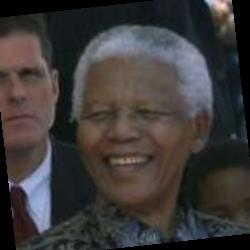

The expected matching gallery image: Nelson_Mandela_0001.jpg


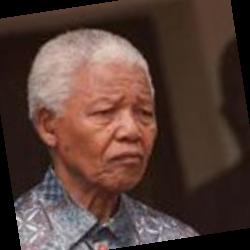

The expected matching gallery image: Nelson_Mandela_0003.jpg


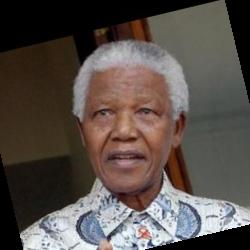

The expected matching gallery image: Nelson_Mandela_0002.jpg


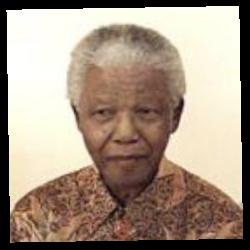

In [9]:
# Select a probe image
probe_image_path = '../storage/probe/Nelson_Mandela/Nelson_Mandela_0002.jpg'
print("The probe image:")
display(Image.open(probe_image_path))

# Get the corresponding gallery images
expected_gallery_dir = os.listdir(os.path.join(GALLERY_IMAGE_DIR, 'Nelson_Mandela'))
for exp_img_name in expected_gallery_dir:
    exp_img_path = os.path.join(GALLERY_IMAGE_DIR, 'Nelson_Mandela', exp_img_name)
    print(f"The expected matching gallery image: {exp_img_name}")
    display(Image.open(exp_img_path))

# Get query vector from probe image
probe_embedding = generate_embedding(MODEL_NAME, probe_image_path)
query = np.array(probe_embedding, dtype=np.float32).reshape(1, -1)



In [10]:
# use the default search method to analyze the nearest neighbor search runtimes.
k = 20  # number of nearest neighbors to retrieve

results = []
# Perform the search using our class method.
for indexing in [index_bf, index_hnsw, index_lsh]:
    distances, indices = indexing.index.search(query, k)
    meta_results = [indexing.get_metadata(int(i)) for i in indices[0]]

    for distance, idx, meta in zip(distances[0], indices[0], meta_results):
        results.append({
            "Indexing_Name": type(indexing).__name__,
            "Distance": distance,
            "Index": idx,
            "Metadata": meta
        })

results = pd.DataFrame(results)
for indexing in results['Indexing_Name'].unique().tolist():
    print(f"Top {k} nearest neighbors for  with {indexing}:")
    display(results.loc[results['Indexing_Name'] == indexing].reset_index(drop=True))

Top 20 nearest neighbors for  with FaissBruteForce:


,Indexing_Name,Distance,Index,Metadata
0,FaissBruteForce,0.266960,1685,Nelson_Mandela_0003.jpg
1,FaissBruteForce,0.324240,1071,Jimmy_Carter_0006.jpg
2,FaissBruteForce,0.340502,489,Dick_Cheney_0006.jpg
3,FaissBruteForce,0.342547,487,Dick_Cheney_0010.jpg
4,FaissBruteForce,0.366855,592,Ferenc_Madl_0001.jpg
5,FaissBruteForce,0.372573,1829,Peter_Struck_0001.jpg
6,FaissBruteForce,0.376163,1069,Jimmy_Carter_0005.jpg
7,FaissBruteForce,0.378852,284,Boris_Becker_0005.jpg
8,FaissBruteForce,0.380223,1141,John_Manley_0002.jpg
9,FaissBruteForce,0.383869,665,George_Pataki_0003.jpg


Top 20 nearest neighbors for  with FaissHNSW:


,Indexing_Name,Distance,Index,Metadata
0,FaissHNSW,0.266960,1685,Nelson_Mandela_0003.jpg
1,FaissHNSW,0.324240,1071,Jimmy_Carter_0006.jpg
2,FaissHNSW,0.340503,489,Dick_Cheney_0006.jpg
3,FaissHNSW,0.342547,487,Dick_Cheney_0010.jpg
4,FaissHNSW,0.366855,592,Ferenc_Madl_0001.jpg
5,FaissHNSW,0.372573,1829,Peter_Struck_0001.jpg
6,FaissHNSW,0.376163,1069,Jimmy_Carter_0005.jpg
7,FaissHNSW,0.378852,284,Boris_Becker_0005.jpg
8,FaissHNSW,0.380223,1141,John_Manley_0002.jpg
9,FaissHNSW,0.383869,665,George_Pataki_0003.jpg


Top 20 nearest neighbors for  with FaissLSH:


,Indexing_Name,Distance,Index,Metadata
0,FaissLSH,15.0,945,James_Kelly_0002.jpg
1,FaissLSH,16.0,1685,Nelson_Mandela_0003.jpg
2,FaissLSH,17.0,1071,Jimmy_Carter_0006.jpg
3,FaissLSH,17.0,1086,Joe_Nichols_0002.jpg
4,FaissLSH,19.0,261,Billy_Graham_0001.jpg
5,FaissLSH,19.0,284,Boris_Becker_0005.jpg
6,FaissLSH,19.0,788,Harvey_Weinstein_0001.jpg
7,FaissLSH,19.0,942,James_Kelly_0009.jpg
8,FaissLSH,19.0,1470,Marc_Grossman_0002.jpg
9,FaissLSH,19.0,1871,Richard_Gephardt_0009.jpg


### Observations

In this section, 3 types of indexing are applied to gallery images for the probe image of "Nelson Mandela" with the settings as below
- Bruteforce: Distance metric: Euclidean distance
- HNSW: Default setting for distance metric; Other params: M=16; efConstruction=50
- LSH: Default setting for distance metric; Other params: nbits=128

#### FAISS BruteForce (Exact Nearest Neighbors)
- **Observations:**
  - The **top result is Nelson Mandela** ("Nelson_Mandela_003.jpg") with the lowest distance (`0.266960`). Another gallery image "Nelson_Mandela_001.jpg" is selected with a lower rank at 11 out of the top 20 neighbors
  - However, one gallery image for Nelson Mandela ("Nelson_Mandela_002.jpg") is **not identified**. 
  - Other high-ranking individuals include **Jimmy Carter, Dick Cheney, and Boris Becker**. 
  - The distances are relatively **small and closely spaced**, meaning similar embeddings are well-separated.
  - Brute-force search is **exact**, so these results represent the most **accurate nearest neighbors**.

- **Interpretation:**
  - The results indicate that **BruteForce retrieves the most semantically similar images based on the embeddings**.

---

#### FAISS HNSW (Hierarchical Graph-Based Approximate Search)
- **Observations:**
  - The results are **almost identical** to BruteForce, with **only minor variations in distance precision** (e.g. `0.340502` vs `0.340503`), suggesting that Euclidean distance is applied as the default setting for HNSW
  - Nelson Mandela is still the **closest match**, followed by the same set of individuals. Similarly, the gallery image "Nelson_Mandela_001.jpg" is selected with a lower rank at 11 out of the top 20 neighbors
  - However, one gallery image for Nelson Mandela ("Nelson_Mandela_002.jpg") is **not identified**. 
  - HNSW preserves high retrieval quality **while being significantly faster than BruteForce**.

- **Interpretation:**
  - **HNSW is highly accurate and retrieves near-identical results** compared to BruteForce.
  - **Graph-based indexing is effective for nearest neighbor search**, especially when balancing speed vs. accuracy.

---

#### FAISS LSH (Locality-Sensitive Hashing - Approximate Search)
- **Observations:**
  - The results differ from BruteForce and HNSW, as LSH is based on Hamming distance rather than Euclidean.
  - **Nelson Mandela is no longer the closest neighbor** (he appears at **position 2**, not 1). 
  - Two gallery images for Nelson Mandela ("Nelson_Mandela_001.jpg" and "Nelson_Mandela_002.jpg") are **not identified**. 
  - The closest match is **James Kelly**, which suggests **LSH retrieval is noisier**.

- **Interpretation:**
  - LSH **sacrifices accuracy for speed**. Its performance is **less reliable** than BruteForce or HNSW for the given case.
  - The **higher distances indicate more quantization errors** in hash-based similarity.

---

#### Key Takeaways
- In the given test, at least one gallery image of Nelson Mandela is identified as the top ranking neighbors. However, at least one image of Nelson Mandela fails to be identified.
- Among the 3 indexing approaches, **HNSW demonstrates fast and reliable nearest neighbor retrieval.**
- BruteForce can be used for **small-scale datasets where accuracy is crucial.**
- There is some **accuracy loss in LSH indexing** based on the given case. 